In [1]:
import os
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
normal_path = '../data/conf/normal/'
down_path = '../data/conf/false/'
abnormal_path = '../data/conf/abnormal'

In [4]:
# 길이 조정 함수
def length_scaling(data, target_length=256):
    current_length = data.shape[0]
    
    scaling_factor = target_length / current_length
    scaled_data = np.zeros((target_length, data.shape[1]))

    for i in range(data.shape[1]):
        scaled_data[:, i] = np.interp(
            np.linspace(0, 1, target_length),
            np.linspace(0, 1, current_length),
            data[:, i]
        )

    return scaled_data


def df_rename(df):
    CM_list = ['CM7', 'CM8', 'CM9']
    
    for CM in CM_list:
        # 컬럼명 변경
        new_columns = {
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_FP': 'FP', # Furnace Pressure
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_CP': 'CP', # Chamber Pressure
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_FT': 'Temperature',
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_FCT': 'Coil Temperature', #코일 온도
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_HEATER_L1': 'Coil T', #코일 압력 T
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_HEATER_L2': 'Coil S', #코일 압력 S
            'CPC_LineB.CPC_PLCB.Global.' + CM + '_DATA_x.COM_PV_HEATER_L3': 'Coil R' #코일 압력 R
            }
        df = df.rename(columns=new_columns)
    
    return df

def df_normalize(df):
    normalized_df = (df - df.min()) / (df.max() - df.min())
    return normalized_df

In [5]:
def make_df(path):
    cols = ['FP', 'CP', 'Temperature', 'Coil Temperature', 'Coil T', 'Coil S', 'Coil R']
    df = []
    
    # 경로 내의 파일 및 폴더 확인
    for root, dirs, files in os.walk(path):
        # 확장자 .csv인 파일 선택
        csv_files = [file for file in files if file.endswith(".csv")]
        
        # csv 파일 처리
        for file in csv_files:
            file_path = os.path.join(root, file)
            
            # CSV 파일 읽고 추가
            csv_data = pd.read_csv(file_path)
            csv_data = df_rename(csv_data)
            csv_data = csv_data[cols].interpolate(method='linear') # 선형 보간
            csv_data = csv_data.dropna(axis=0).reset_index(drop=True)
            csv_data = df_normalize(csv_data)
            df.append(csv_data)
    
    # Pandas DataFrame => NumPy
    df_array = np.array([length_scaling(dataframe.values, 256) for dataframe in df if len(dataframe.values)])
        
    return df, df_array

In [6]:
temp, normal_df = make_df(normal_path)
_,down_df = make_df(down_path)
_, abnormal_df = make_df(abnormal_path)    

In [7]:
print(normal_df.shape)
print(down_df.shape)
print(abnormal_df.shape)

(4071, 256, 7)
(716, 256, 7)
(146, 256, 7)


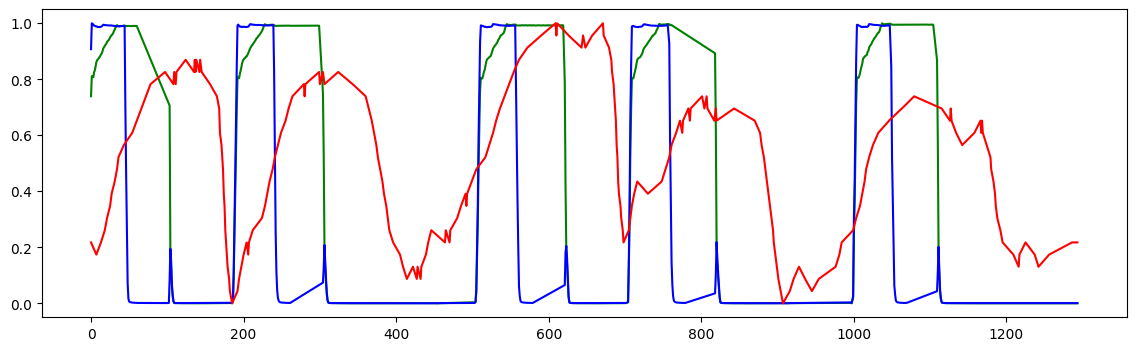

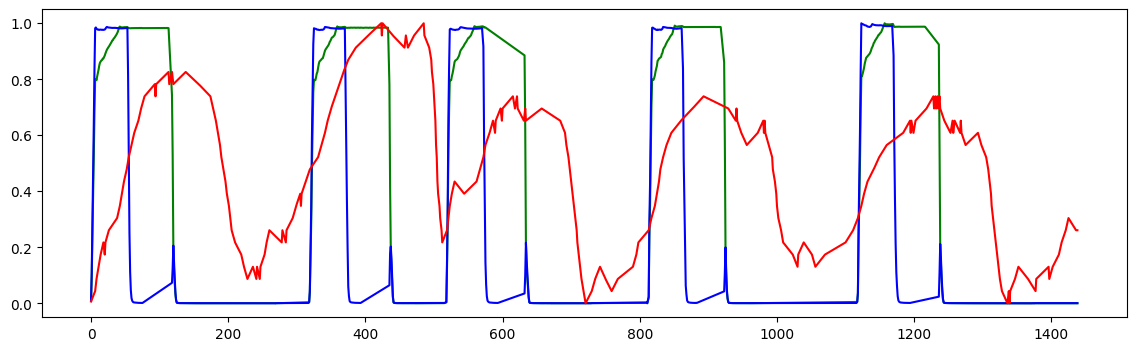

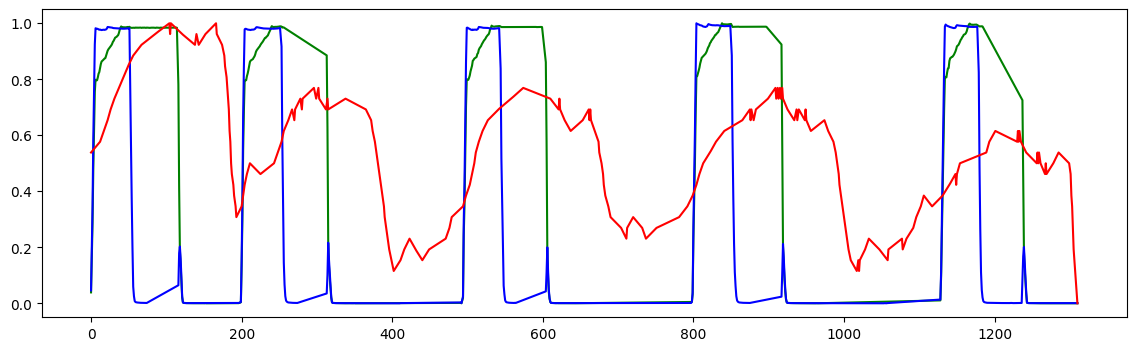

In [8]:
for i in range(3):
    t = temp[i]
    plt.figure(figsize=(14,4))
    plt.plot(t['FP'], color = 'green')
    plt.plot(t['CP'], color = 'blue')
    plt.plot(t['Temperature'], color = 'red')
    #plt.plot(t['Cast'], color='gold')
    plt.show()

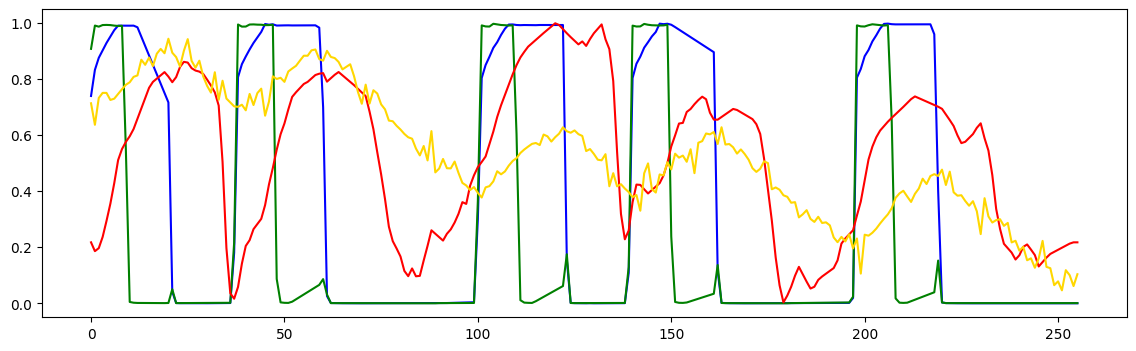

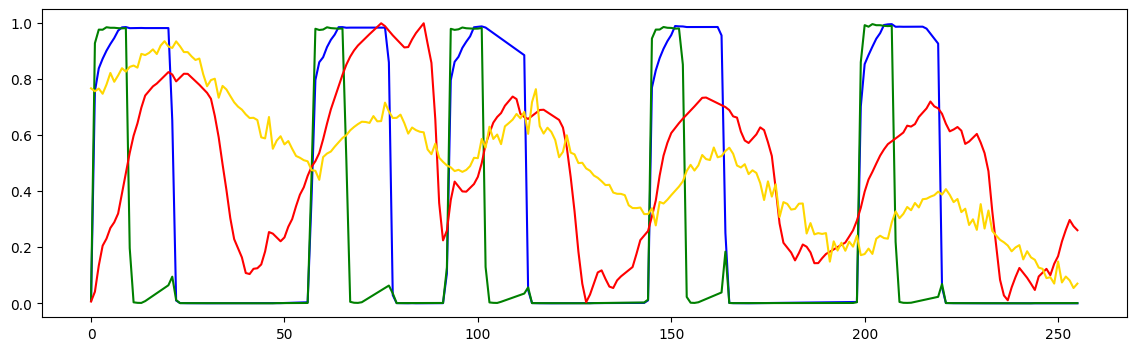

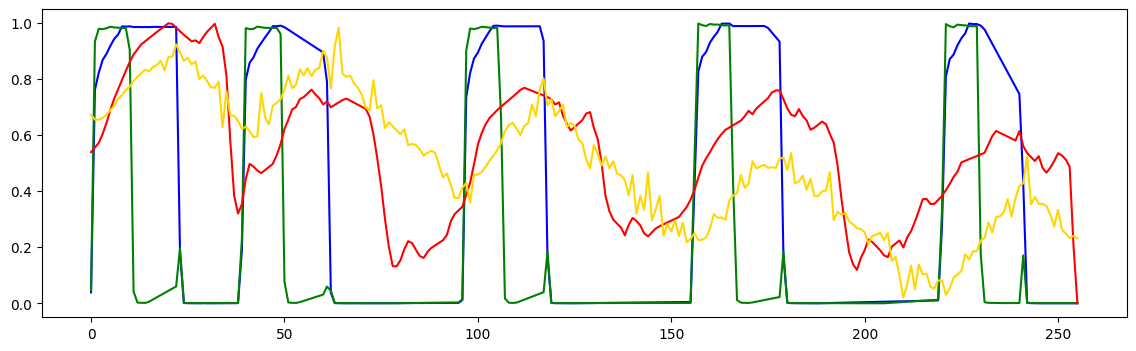

In [9]:
for i in range(3):
    t = normal_df[i]    
    #t = abnormal_df[i]    
    #t = down_df[i]    
    plt.figure(figsize=(14,4))
    plt.plot(t[:,0], color = 'blue')
    plt.plot(t[:,1], color = 'green')
    plt.plot(t[:,2], color = 'red')
    plt.plot(t[:,3], color = 'gold')
    plt.show()

In [10]:
class LSTMAutoEncoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout=0, device=torch.device('cpu')):
        super(LSTMAutoEncoder, self).__init__()
        self.device = device
        self.encoder = Encoder(num_layers, hidden_size, nb_feature, dropout, device)
        self.decoder = Decoder(num_layers, hidden_size, nb_feature, dropout, device)

    def forward(self, input_seq):
        output = torch.zeros(size=input_seq.shape, dtype=torch.float)
        hidden_cell = self.encoder(input_seq)
        input_decoder = input_seq[:, -1, :].view(input_seq.shape[0], 1, input_seq.shape[2])
        for i in range(input_seq.shape[1] - 1, -1, -1):
            output_decoder, hidden_cell = self.decoder(input_decoder, hidden_cell)
            input_decoder = output_decoder
            output[:, i, :] = output_decoder[:, 0, :]
        return output


class Encoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout, device):
        super(Encoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)

    def initHidden(self, batch_size):
        self.hidden_cell = (
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device),
            torch.randn((self.num_layers, batch_size, self.hidden_size), dtype=torch.float).to(self.device)
        )

    def forward(self, input_seq):
        self.initHidden(input_seq.shape[0])
        _, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        return self.hidden_cell


class Decoder(nn.Module):
    def __init__(self, num_layers, hidden_size, nb_feature, dropout, device):
        super(Decoder, self).__init__()

        self.input_size = nb_feature
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device

        self.lstm = nn.LSTM(input_size=nb_feature, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True, dropout=dropout, bias=True)
        self.linear = nn.Linear(in_features=hidden_size, out_features=nb_feature)

    def forward(self, input_seq, hidden_cell):
        output, hidden_cell = self.lstm(input_seq, hidden_cell)
        output = self.linear(output)
        return output, hidden_cell

In [11]:
def create_dataset(df):
    temp = df.tolist()
    dataset = [torch.tensor(s).float() for s in temp]
    
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    
    return dataset, seq_len, n_features

In [12]:
class LossCheckpoint:
    def __init__(self):
        self.losses = []

    def plot(self, log=False):
        plt.figure(figsize=(10, 5))
        plt.plot(range(len(self.losses)), self.losses)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        if log:
            plt.yscale('log')
        plt.show()
        
class EarlyStopping:
    def __init__(self, patience=0):
        self.last_metrics = 10**8
        self.patience = patience
        self.patience_count = 0

    def check_training(self, metric):
        if metric < self.last_metrics:
            self.last_metrics = metric
            self.patience_count = 0
            return False
        elif (metric > self.last_metrics) & (self.patience_count < self.patience):
            self.patience_count += 1
            return False
        else:
            return True

In [13]:
class ModelManagement:
    def __init__(self, path, name_model):
        self.path = path
        self.last_metrics = 10**8
        self.name_model = name_model
        self.dict_model = None

    def save(self, model):
        torch.save(model.state_dict(), self.path + '%s' % self.name_model)

    def checkpoint(self, epoch, model, optimizer, loss):
        if self.last_metrics > loss:
            self.dict_model = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
            }
            self.last_metrics = loss

    def save_best_model(self):
        torch.save(self.dict_model, self.path + '%s_epoch_%d' % (self.name_model, self.dict_model['epoch']))

In [14]:
train_df, val_df = train_test_split(normal_df, test_size=0.4, random_state=1209)
train_down_df, val_down_df = train_test_split(down_df, test_size = 0.4, random_state=1209)


train_dataset, seq_len, n_features = create_dataset(train_df)
train_down_dataset, seq_len, n_features = create_dataset(train_down_df)

val_dataset, _, _ = create_dataset(val_df)
val_down_dataset, _, _ = create_dataset(val_down_df)

test_dataset, _, _ = create_dataset(abnormal_df)

In [15]:
def train(epoch, train_loader):
    model.train()
    train_loss = 0
    for id_batch, data in enumerate(train_loader):
        optimizer.zero_grad()
        # forward
        data = data.to(device)
        output = model.forward(data)
        loss = criterion(data, output.to(device))
        # backward
        loss.backward()
        train_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.3)
        optimizer.step()

        print('\r', 'Training [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
            id_batch + 1, len(train_loader),
            (id_batch + 1) * 100 / len(train_loader),
            loss.item()), sep='', end='', flush=True)

    avg_loss = train_loss / len(train_loader)
    print('====> Epoch: {} Average loss: {:.6f}'.format(epoch, avg_loss))
    loss_checkpoint_train.losses.append(avg_loss)

In [16]:
def evaluate(loader, validation=False, epoch=0):
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for id_batch, data in enumerate(loader):
            data = data.to(device)
            output = model.forward(data)
            loss = criterion(data, output.to(device))
            eval_loss += loss.item()
        print('\r', 'Eval [{}/{} ({:.0f}%)] \tLoss: {:.6f})]'.format(
            id_batch + 1, len(loader),
            (id_batch + 1) * 100 / len(loader),
            loss.item()), sep='', end='', flush=True)
    avg_loss = eval_loss / len(loader)
    print('====> Validation Average loss: {:.6f}'.format(avg_loss))
    # Checkpoint
    if validation:
        loss_checkpoint_valid.losses.append(avg_loss)
        model_management.checkpoint(epoch, model, optimizer, avg_loss)
        return earlyStopping.check_training(avg_loss)

# 1st-Stage Train

In [17]:
hidden_size = 32
num_layers = 4
batch_size = 128

model_path = '../model/conf/first/'
name_model = f'lstm_{hidden_size}_{num_layers}_(len256)'
model_management = ModelManagement(model_path, name_model)

In [18]:
model = LSTMAutoEncoder(num_layers, hidden_size, n_features, device=device)
model = model.to(device)

In [19]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss
criterion = torch.nn.MSELoss()
# Callbacks
earlyStopping = EarlyStopping(patience=10)
# Plot
loss_checkpoint_train = LossCheckpoint()
loss_checkpoint_valid = LossCheckpoint()

In [20]:
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [ ]:
epochs = 600

for epoch in range(1, epochs+1):
    train(epoch, train_loader)
    evaluate(valid_loader, validation=True, epoch=epoch)
    '''
    if earlyStopping.patience_count == 20:
        print('lr on plateau ', optimizer.param_groups[0]['lr'], ' -> ', optimizer.param_groups[0]['lr'] /10)
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] /10
    '''

Training [20/20 (100%)] 	Loss: 0.128945)]====> Epoch: 1 Average loss: 0.239629
Eval [13/13 (100%)] 	Loss: 0.123184)]====> Validation Average loss: 0.122397
Training [20/20 (100%)] 	Loss: 0.105537)]====> Epoch: 2 Average loss: 0.113704
Eval [13/13 (100%)] 	Loss: 0.107596)]====> Validation Average loss: 0.107196
Training [20/20 (100%)] 	Loss: 0.099507)]====> Epoch: 3 Average loss: 0.105851
Eval [13/13 (100%)] 	Loss: 0.105511)]====> Validation Average loss: 0.104560
Training [20/20 (100%)] 	Loss: 0.105259)]====> Epoch: 4 Average loss: 0.104914
Eval [13/13 (100%)] 	Loss: 0.103731)]====> Validation Average loss: 0.103788
Training [20/20 (100%)] 	Loss: 0.102443)]====> Epoch: 5 Average loss: 0.104197
Eval [13/13 (100%)] 	Loss: 0.102907)]====> Validation Average loss: 0.103199
Training [20/20 (100%)] 	Loss: 0.108261)]====> Epoch: 6 Average loss: 0.103904
Eval [13/13 (100%)] 	Loss: 0.100494)]====> Validation Average loss: 0.102580
Training [20/20 (100%)] 	Loss: 0.102567)]====> Epoch: 7 Average 

In [ ]:
model_management.save_best_model()

In [ ]:
loss_checkpoint_train.plot()
loss_checkpoint_valid.plot()

# 2nd-Stage Train

In [ ]:
hidden_size = 32
num_layers = 4
batch_size = 64

model_path = '../model/conf/second/'
name_model = f'lstm_{hidden_size}_{num_layers}_(len256)'
model_management = ModelManagement(model_path, name_model)

In [ ]:
model = LSTMAutoEncoder(num_layers, hidden_size, n_features, device=device)
model = model.to(device)

In [ ]:
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss
criterion = torch.nn.MSELoss()
# Callbacks
earlyStopping = EarlyStopping(patience=10)
# Plot
loss_checkpoint_train = LossCheckpoint()
loss_checkpoint_valid = LossCheckpoint()

In [ ]:
train_loader = DataLoader(train_down_dataset, batch_size, shuffle=True)
valid_loader = DataLoader(val_down_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

In [ ]:
epochs = 500

for epoch in range(1, epochs+1):
    train(epoch, train_loader)
    evaluate(valid_loader, validation=True, epoch=epoch)
    '''
    if earlyStopping.patience_count == 20:
        print('lr on plateau ', optimizer.param_groups[0]['lr'], ' -> ', optimizer.param_groups[0]['lr'] /10)
        optimizer.param_groups[0]['lr'] = optimizer.param_groups[0]['lr'] /10
    '''

In [ ]:
model_management.save_best_model()

In [ ]:
loss_checkpoint_train.plot()
loss_checkpoint_valid.plot()

# Prediction

In [ ]:
hidden_size = 32
num_layers = 4
model_best = LSTMAutoEncoder(num_layers, hidden_size, n_features, device=device)
checkpoint = torch.load('../model/conf/first/lstm_32_4_(len256)_epoch_400')
model_best.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
print(len(val_dataset), len(test_dataset))

In [ ]:
model_best.to(device)

In [ ]:
val_anomalies=0
val_loss = [0 for _ in range(len(val_dataset))]
test_loss = [0 for _ in range(len(test_dataset))]

with torch.no_grad():
    for i in range(len(val_dataset)):
        data = val_dataset[i]
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        val_loss[i] = loss

with torch.no_grad():
    for i in range(len(test_dataset)):
        data = test_dataset[i]
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        test_loss[i] = loss

In [ ]:
# threshold 임의 지정
threshold = 0.036
val_anomal = 0
test_anomal = 0

for loss in val_loss:
    if loss > threshold:
        val_anomal +=1
        
for loss in test_loss:
    if loss > threshold:
        test_anomal +=1
        
print(f'validataion anomal = {val_anomal}')
print(f'test anomal = {test_anomal}')

In [ ]:
thresholds = np.arange(0, 0.15, 0.0001)

accuracy_list = [0 for _ in range(len(thresholds))]
precision_list = [0 for _ in range(len(thresholds))]
recall_list = [0 for _ in range(len(thresholds))]
F1_list = [0 for _ in range(len(thresholds))]

for i in range(len(thresholds)):
    threshold = thresholds[i]
    val_anomal = 0
    test_anomal = 0
    
    for loss in val_loss:
        if loss > threshold:
            val_anomal += 1
    
    for loss in test_loss:
        if loss > threshold:
            test_anomal += 1
            
    TP = test_anomal
    FP = val_anomal
    TN = len(val_dataset)-val_anomal
    FN = len(test_dataset)-test_anomal
    
    accuracy = (TP+TN) / (TP+FP+TN+FN)
    precision = TP / (TP+FP)
    recall = TP / (TP+FN)
    F1 = 2 / (1/precision + 1/recall)

    accuracy_list[i] = accuracy
    precision_list[i] = precision
    recall_list[i] = recall
    F1_list[i] = F1
    

In [ ]:
min_dist = 10
idx = 0

for i in range(len(thresholds)):
    precision, recall = precision_list[i], recall_list[i]
    
    if min_dist > abs(precision-recall):
        min_dist, idx = abs(precision-recall), i

In [ ]:
thresholds[idx]

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, precision_list, label = 'Precision')
plt.plot(thresholds, recall_list, label = 'Recall')
plt.axvline(thresholds[idx], color='red', linestyle='--', linewidth=1)
plt.legend()
plt.show()

In [ ]:
print(f'Accuracy // Precision // Recall // F1-Score')
print(f'{accuracy_list[idx]} // {precision_list[idx]} // {recall_list[idx]} // {F1_list[idx]}')

In [ ]:
# 실제 down 도 노말에 포함돼야 함
normal_df = np.concatenate((val_df,down_df), axis=0)
normal_dataset, _, _ = create_dataset(normal_df)

In [ ]:
val_loss = []
test_loss = []

with torch.no_grad():
    for data in normal_dataset:
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        val_loss.append(loss)
        #if loss > threshold:

with torch.no_grad():
    for data in test_dataset:
        data = data.unsqueeze(0).to(device)
        output = model_best.forward(data).to(device)
        loss = criterion(data, output)
        test_loss.append(loss)
        #if loss > threshold:

In [ ]:
thresholds = np.arange(0, 0.15, 0.0001)

accuracy_list = [0 for _ in range(len(thresholds))]
precision_list = [0 for _ in range(len(thresholds))]
recall_list = [0 for _ in range(len(thresholds))]
F1_list = [0 for _ in range(len(thresholds))]

for i in range(len(thresholds)):
    threshold = thresholds[i]
    val_anomal = 0
    test_anomal = 0
    
    for loss in val_loss:
        if loss > threshold:
            val_anomal += 1
    
    for loss in test_loss:
        if loss > threshold:
            test_anomal += 1
            
    TP = test_anomal
    FP = val_anomal
    TN = len(val_dataset)-val_anomal
    FN = len(test_dataset)-test_anomal
    
    accuracy = (TP+TN) / (TP+FP+TN+FN)
    precision = TP / (TP+FP) # 알람 울린 모든 상황에서, 진짜 알람 울린 비율
    recall = TP / (TP+FN) # 알람을 울려야 했던 모든 상황 중에서, 진짜 알람 울린 비율
    F1 = 2 / (1/precision + 1/recall)

    accuracy_list[i] = accuracy
    precision_list[i] = precision
    recall_list[i] = recall
    F1_list[i] = F1

In [ ]:
min_dist = 10
idx = 0

for i in range(len(thresholds)):
    precision, recall = precision_list[i], recall_list[i]
    
    if min_dist > abs(precision-recall):
        min_dist, idx = abs(precision-recall), i

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(thresholds, precision_list, label = 'Precision')
plt.plot(thresholds, recall_list, label = 'Recall')
plt.axvline(thresholds[idx], color='red', linestyle='--', linewidth=1)
plt.legend()
plt.show()

In [ ]:
print(f'Accuracy // Precision // Recall // F1-Score')
print(f'{accuracy_list[idx]} // {precision_list[idx]} // {recall_list[idx]} // {F1_list[idx]}')